In [16]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import shutil
import matplotlib.pyplot as plt
%matplotlib inline 
from tensorflow.keras.utils import img_to_array, load_img

from IPython.display import Image, display
from sklearn.model_selection import train_test_split
from keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import torch

import os
print(os.listdir("leafimages/train"))
# Any results you write to the current directory are saved as output.

['Alstonia Scholaris (P2)_diseased', 'Alstonia Scholaris (P2)_healthy', 'Arjun (P1)_diseased', 'Arjun (P1)_healthy', 'Chinar (P11)_diseased', 'Chinar (P11)_healthy', 'Gauva (P3)_diseased', 'Gauva (P3)_healthy', 'Jamun (P5)_diseased', 'Jamun (P5)_healthy', 'Jatropha (P6)_diseased', 'Jatropha (P6)_healthy', 'Lemon (P10)_diseased', 'Lemon (P10)_healthy', 'Mango (P0)_diseased', 'Mango (P0)_healthy', 'Pomegranate (P9)_diseased', 'Pomegranate (P9)_healthy', 'Pongamia Pinnata (P7)_diseased', 'Pongamia Pinnata (P7)_healthy']


In [ ]:
#this basically takes one leaf image from every file in the dataset and prints the name of the leaf with the image. it gets the name from the folder name.
image_paths=[]
names=[]
root="leafimages/train/"
for folder in os.listdir(root):
    fi=os.listdir(root+folder)[0]
    image_paths.append(root+"/"+folder+"/"+fi)
    c=0
    w=""
    for a in folder[::-1]:
       if a==" ":
           c=1
       if c==1:
            w+=a
    names.append(w[::-1])

num_rows = 4
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 8))
axes = axes.flatten()
for i, image_path in enumerate(image_paths):
    img=load_img(image_path, target_size=(256,256))
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].text(0.5, -0.1, names[i], size=10, ha="center", transform=axes[i].transAxes)


plt.tight_layout()

# Show the plot
plt.show()

In [20]:
labels = os.listdir("leafimages/train")

NameError: name 'os' is not defined

In [7]:
num_classes = len(set(labels))
resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Create model
model = Sequential()
model.add(ResNet50(include_top=False, pooling='avg', weights="imagenet"))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Do not train first layer (ResNet) as it is already pre-trained
model.layers[0].trainable = False

# Compile model
from tensorflow.keras import optimizers

# sgd = optimizers.SGD(learning_rate= 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 20)                5140      
                                                                 
Total params: 24117396 (92.00 MB)
Trainable params: 529684 (2.02 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [9]:
train_folder = 'leafimages/train'

image_size = 224
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                    horizontal_flip=True,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    validation_split=0.2)# set validation split

train_generator = data_generator.flow_from_directory(
    train_folder,
    target_size=(image_size, image_size),
    batch_size=24,
    class_mode='categorical',
    subset='training'
    )
validation_generator = data_generator.flow_from_directory(
    train_folder,
    target_size=(image_size, image_size),
    batch_size=24,
    class_mode='categorical',
    subset='validation'
    )

Found 2726 images belonging to 20 classes.
Found 671 images belonging to 20 classes.


In [19]:
t_img, label=train_generator.next()
def plotimg(imgarr,label):
    for im, l in zip(imgarr,label):
        plt.figure(figsize=(5,5))
        plt.imshow(im/255)
        plt.show()

In [ ]:
count=3 #change this to print the number of preprocessed images
plotimg(t_img[:count],label[:count])

In [21]:
NUM_EPOCHS = 5
EARLY_STOP_PATIENCE = 5

In [13]:
# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = 'best.hdf5',
                                  monitor = 'val_loss',
                                  save_best_only = True,
                                  mode = 'auto')

In [13]:
import math

fit_history = model.fit_generator(
    train_generator,
    steps_per_epoch=10,
    validation_data=validation_generator,
    validation_steps=10,
    epochs=NUM_EPOCHS,
    callbacks=[cb_checkpointer, cb_early_stopper])


C:\Users\Anudeep Bura\AppData\Local\Temp\ipykernel_1432\3894681618.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fit_history = model.fit_generator(


Epoch 1/5
10/10 [==============================] - ETA: 0s - loss: 3.2663 - accuracy: 0.1417

c:\Users\Anudeep Bura\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 137s 14s/step - loss: 3.2663 - accuracy: 0.1417 - val_loss: 2.3585 - val_accuracy: 0.3083
Epoch 2/5
10/10 [==============================] - 122s 13s/step - loss: 2.5382 - accuracy: 0.2500 - val_loss: 1.9841 - val_accuracy: 0.4542
Epoch 3/5
10/10 [==============================] - 122s 13s/step - loss: 2.0749 - accuracy: 0.3667 - val_loss: 1.7154 - val_accuracy: 0.5333
Epoch 4/5
10/10 [==============================] - 108s 11s/step - loss: 1.8801 - accuracy: 0.4167 - val_loss: 1.5844 - val_accuracy: 0.6000
Epoch 5/5
10/10 [==============================] - 104s 11s/step - loss: 1.5447 - accuracy: 0.5208 - val_loss: 1.3186 - val_accuracy: 0.5917


In [ ]:

model.load_weights("best.hdf5")

In [14]:
print(fit_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


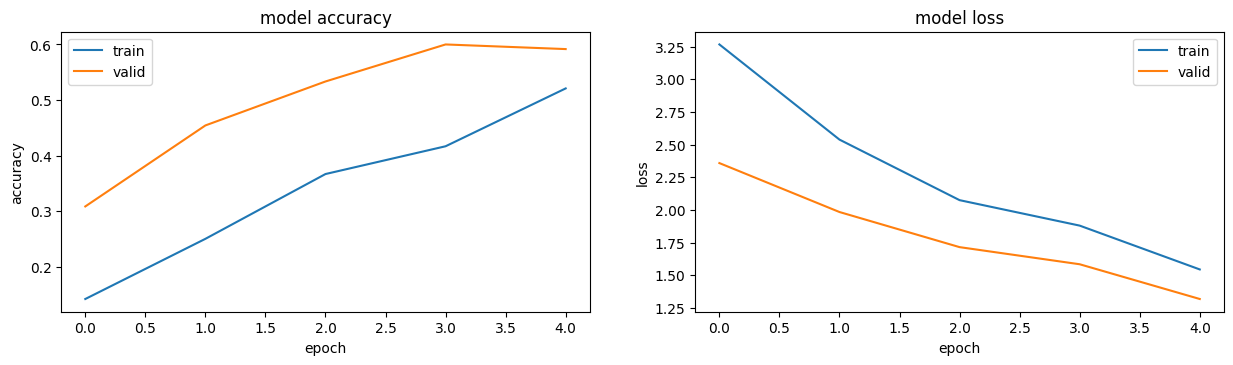

In [15]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])  
plt.plot(fit_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [16]:
from tensorflow.keras.utils import img_to_array, load_img
import numpy as np
path="leafimages/train/Alstonia Scholaris (P2)_diseased/0014_0003.JPG"
img=load_img(path, target_size=(256,256))

i=img_to_array(img)
img=np.expand_dims(i,axis=0)
pred=np.argmax(model.predict(img))
print(pred)

1/1 [==============================] - 1s 1s/step
9


In [18]:
ref=dict(zip(list(train_generator.class_indices.values()),list(train_generator.class_indices.keys())))
print(ref)

{0: 'Alstonia Scholaris (P2)_diseased', 1: 'Alstonia Scholaris (P2)_healthy', 2: 'Arjun (P1)_diseased', 3: 'Arjun (P1)_healthy', 4: 'Chinar (P11)_diseased', 5: 'Chinar (P11)_healthy', 6: 'Gauva (P3)_diseased', 7: 'Gauva (P3)_healthy', 8: 'Jamun (P5)_diseased', 9: 'Jamun (P5)_healthy', 10: 'Jatropha (P6)_diseased', 11: 'Jatropha (P6)_healthy', 12: 'Lemon (P10)_diseased', 13: 'Lemon (P10)_healthy', 14: 'Mango (P0)_diseased', 15: 'Mango (P0)_healthy', 16: 'Pomegranate (P9)_diseased', 17: 'Pomegranate (P9)_healthy', 18: 'Pongamia Pinnata (P7)_diseased', 19: 'Pongamia Pinnata (P7)_healthy'}


In [ ]:
import torch
def drawbounding(path,dis):
    model = torch.hub.load('yolov5','custom', path="last_t.pt",source='local')
    results = model(path)
    results.show()
    areas=[]
    den=0
    num=0
    box=results.xyxy[0]
    for i in range(len(box)):
        area=(float(box[i][0])-float(box[i][2]))*(float(box[i][1])-float(box[i][3]))
        areas.append(areas)
        if i==0:
            den+=area
        else:
            num+=area
    print("infected area:"+str((num/den)*100)+"%")

In [19]:
import matplotlib.pyplot as plt
ref=dict(zip(list(train_generator.class_indices.values()),list(train_generator.class_indices.keys())))
def predi(path):
    img=load_img(path, target_size=(256,256))
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    i=img_to_array(img)
    img=np.expand_dims(i,axis=0)
    pred=np.argmax(model.predict(img))
    print(ref[pred])
    drawbounding(path,pred)
    plt.title("class: "+ref[pred])
    
    plt.show()

In [ ]:
predi(path)

In [ ]:
import torch
path="leafimages/val/Pomegranate (P9)_diseased/0020_0027.JPG"
model = torch.hub.load('yolov5','custom', path="last_t.pt",source='local')
results = model(path)
results.show()


In [16]:
print('\n', float(results.xyxy[0][0][0]))



 2236.875


1843819.2370762825

In [17]:
len(box)

7

In [18]:
areas=[]
den=0
num=0
box=results.xyxy[0]
for i in range(len(box)):
    area=(float(box[i][0])-float(box[i][2]))*(float(box[i][1])-float(box[i][3]))
    areas.append(areas)
    if i==0:
        den+=area
    else:
        num+=area
print((num/den)*100)

69.80123332982643


In [ ]:
path="leafimages/val/Jamun (P5)_diseased/0017_0011.JPG"
drawbounding(path)